# Week 5 Capstone Assignment: Clustering Neighborhoods in Moline, IL

First, read in our csv file containing the latitude and longitude data for the 26 historic neighborhoods in Moline, IL

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Latitude,Longitude
0,Hamilton Heights,41.482842,-90.530083
1,Wildwood,41.477037,-90.532671
2,Prospect Park,41.478408,-90.511999
3,Park Hill,41.506183,-90.503201
4,Forest Hill,41.495790,-90.500719


In [3]:
#number of rows in dataframe
Moline_Neighborhood_Data.shape

(26, 3)

In [4]:
#list the unique historic Neighborhood names
Moline_Neighborhood_Data.Neighborhood.unique()

array(['Hamilton Heights', 'Wildwood', 'Prospect Park', 'Park Hill',
       'Forest Hill', 'Highland', 'Villa Park', 'Green Acres', 'Molette',
       'Rockview Estates', 'Homewood', 'Heritage', 'Stewartville',
       'Deerview', 'Walton Hills', 'Olde Towne', 'Uptown',
       'Willard/Wharton', 'Karstens/City Line', 'Morgan Park',
       'Greater Tartan Oaks', 'Overlook', 'Floreciente',
       'Keystone Neighborhood', 'Wheelock/Velie', 'Downtown'],
      dtype=object)

In [5]:
import json # library to handle JSON files

#!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#importing libraries for clustering and map creation
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium  # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 9.2MB/s ta 0:00:011
Libraries imported.


Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'FSX0VX3LF2T0OCJCSZXQ4DS4VHD2GCBKH3A5TEMEFTBU1SFU' # your Foursquare ID
CLIENT_SECRET = 'DU05GD5PHMFAF4O1YVBY5DSXN4E00JDEHCF2QRSI30D3ZBOG' # your Foursquare Secret
VERSION = '20200506' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FSX0VX3LF2T0OCJCSZXQ4DS4VHD2GCBKH3A5TEMEFTBU1SFU
CLIENT_SECRET:DU05GD5PHMFAF4O1YVBY5DSXN4E00JDEHCF2QRSI30D3ZBOG


Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to repeat the same process to all the neighborhoods in Moline

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)#set LIMIT = 100
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called moline_venues.

In [9]:
moline_venues = getNearbyVenues(names=Moline_Neighborhood_Data['Neighborhood'],
                                   latitudes=Moline_Neighborhood_Data['Latitude'],
                                   longitudes=Moline_Neighborhood_Data['Longitude']
                                  )

Hamilton Heights
Wildwood
Prospect Park
Park Hill
Forest Hill
Highland
Villa Park
Green Acres
Molette
Rockview Estates
Homewood
Heritage
Stewartville
Deerview
Walton Hills
Olde Towne
Uptown
Willard/Wharton
Karstens/City Line
Morgan Park
Greater Tartan Oaks
Overlook
Floreciente
Keystone Neighborhood
Wheelock/Velie
Downtown


Let's check the size of the resulting dataframe

In [10]:
print(moline_venues.shape)
moline_venues.head()

(190, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hamilton Heights,41.482842,-90.530083,Katy's Import Foods,41.484892,-90.527940,Gourmet Shop
1,Prospect Park,41.478408,-90.511999,Quad City Music Guild,41.478223,-90.510541,Concert Hall
2,Prospect Park,41.478408,-90.511999,Prospect Park,41.478976,-90.512139,Park
3,Prospect Park,41.478408,-90.511999,Walgreens,41.476558,-90.507278,Pharmacy
4,Prospect Park,41.478408,-90.511999,7-Eleven,41.482688,-90.511776,Convenience Store


Let's check how many venues were returned for each neighborhood

In [11]:
moline_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Deerview,2,2,2,2,2,2
Downtown,41,41,41,41,41,41
Floreciente,3,3,3,3,3,3
Forest Hill,5,5,5,5,5,5
Greater Tartan Oaks,14,14,14,14,14,14
Hamilton Heights,1,1,1,1,1,1
Highland,11,11,11,11,11,11
Homewood,2,2,2,2,2,2
Karstens/City Line,12,12,12,12,12,12


Let's find out how many unique categories can be curated from all the returned venues

In [12]:
print('There are {} uniques categories.'.format(len(moline_venues['Venue Category'].unique())))

There are 75 uniques categories.


Analyze Each Neighborhood

In [13]:
# one hot encoding
moline_onehot = pd.get_dummies(moline_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
moline_onehot['Neighborhood'] = moline_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [moline_onehot.columns[-1]] + list(moline_onehot.columns[:-1])
moline_onehot = moline_onehot[fixed_columns]

moline_onehot.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,Bakery,Bank,Bar,Basketball Court,Beer Bar,...,Stadium,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Veterinarian,Video Store,Vietnamese Restaurant
0,Hamilton Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Prospect Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Prospect Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Prospect Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Prospect Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size

In [14]:
moline_onehot.shape

(190, 76)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [15]:
moline_grouped = moline_onehot.groupby('Neighborhood').mean().reset_index()
moline_grouped

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,Bakery,Bank,Bar,Basketball Court,Beer Bar,...,Stadium,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Veterinarian,Video Store,Vietnamese Restaurant
0,Deerview,0.00000,0.5,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000
1,Downtown,0.02439,0.0,0.000000,0.0,0.000000,0.02439,0.073171,0.00,0.02439,...,0.02439,0.02439,0.000000,0.000000,0.02439,0.00,0.000000,0.000000,0.000000,0.02439
2,Floreciente,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000
3,Forest Hill,0.00000,0.0,0.000000,0.2,0.000000,0.00000,0.200000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.200000,0.00000
4,Greater Tartan Oaks,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.142857,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000
5,Hamilton Heights,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000
6,Highland,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.090909,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000
7,Homewood,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.50,0.000000,0.000000,0.000000,0.00000
8,Karstens/City Line,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.083333,0.000000,0.00000,0.00,0.000000,0.083333,0.083333,0.00000
9,Keystone Neighborhood,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00,0.00000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.25,0.000000,0.000000,0.000000,0.00000


Let's confirm the new size

In [16]:
moline_grouped.shape

(22, 76)

Let's print each neighborhood along with the top 5 most common venues

In [17]:
num_top_venues = 5

for hood in moline_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = moline_grouped[moline_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Deerview----
                 venue  freq
0  Arts & Crafts Store   0.5
1            Gift Shop   0.5
2               Lawyer   0.0
3          Pizza Place   0.0
4             Pharmacy   0.0


----Downtown----
     venue  freq
0    Hotel  0.07
1      Bar  0.07
2      Pub  0.07
3  Brewery  0.05
4     Café  0.05


----Floreciente----
                 venue  freq
0                 Park  0.33
1   Mexican Restaurant  0.33
2       Discount Store  0.33
3  American Restaurant  0.00
4       Massage Studio  0.00


----Forest Hill----
               venue  freq
0  Convenience Store   0.2
1        Video Store   0.2
2        Auto Garage   0.2
3        Pizza Place   0.2
4                Bar   0.2


----Greater Tartan Oaks----
                venue  freq
0      Ice Cream Shop  0.21
1  Mexican Restaurant  0.14
2                 Bar  0.14
3      Hardware Store  0.07
4           Gift Shop  0.07


----Hamilton Heights----
          venue  freq
0  Gourmet Shop   1.0
1           Pub   0.0
2   Pizza Place  

Let's put that into a pandas dataframe  
First, let's write a function to sort the venues in descending order.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [19]:
import numpy as np # library to handle data in a vectorized manner

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = moline_grouped['Neighborhood']

for ind in np.arange(moline_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moline_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Deerview,Gift Shop,Arts & Crafts Store,Discount Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner,Disc Golf
1,Downtown,Bar,Pub,Hotel,Harbor / Marina,Brewery,Café,Sandwich Place,Mexican Restaurant,Vietnamese Restaurant,Karaoke Bar
2,Floreciente,Park,Mexican Restaurant,Discount Store,Vietnamese Restaurant,Diner,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio
3,Forest Hill,Video Store,Auto Garage,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Farmers Market,Fish & Chips Shop,Electronics Store,Donut Shop
4,Greater Tartan Oaks,Ice Cream Shop,Bar,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Pet Store,Hardware Store,Pawn Shop,Donut Shop,Gift Shop


Cluster Neighborhoods:  
First, we want to determine if there is an ideal target number of clusters by plotting the results of various K values and looking for the "elbow"

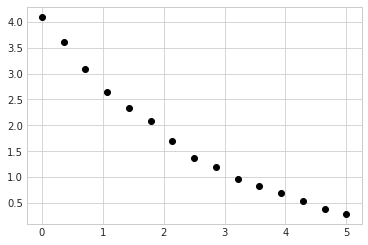

In [43]:
inertia=[]
for k in range(2,17):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(moline_grouped_clustering)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
x = np.linspace(0, 5, 15)
plt.plot(x, inertia, 'o', color='black');

Since there is no clear "Elbow", we are just going to pick 5 clusters  
Now, we will run k-means to cluster the neighborhoods 

In [29]:
# set number of clusters
kclusters = 5

moline_grouped_clustering = moline_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moline_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 0, 4, 0, 0], dtype=int32)

In [55]:
type(kclusters)

int

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

moline_merged = Moline_Neighborhood_Data

# merge moline_grouped with moline_data to add latitude/longitude for each neighborhood
moline_merged = moline_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

moline_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

In [33]:
moline_merged # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamilton Heights,41.482842,-90.530083,1.0,Gourmet Shop,Concert Hall,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner,Disc Golf,Discount Store
1,Wildwood,41.477037,-90.532671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Prospect Park,41.478408,-90.511999,0.0,Salon / Barbershop,Pharmacy,Convenience Store,Park,Disc Golf,Concert Hall,Design Studio,Cosmetics Shop,Dance Studio,Deli / Bodega
3,Park Hill,41.506183,-90.503201,2.0,Gas Station,Electronics Store,Vietnamese Restaurant,Disc Golf,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner
4,Forest Hill,41.495790,-90.500719,0.0,Video Store,Auto Garage,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Farmers Market,Fish & Chips Shop,Electronics Store,Donut Shop
5,Highland,41.493566,-90.492665,0.0,Pizza Place,Shoe Store,Fast Food Restaurant,Grocery Store,Hobby Shop,Department Store,Mexican Restaurant,Restaurant,Business Service,Gas Station
6,Villa Park,41.487960,-90.494156,0.0,Gas Station,Grocery Store,Asian Restaurant,Restaurant,Department Store,Business Service,Disc Golf,Dance Studio,Deli / Bodega,Design Studio
7,Green Acres,41.483062,-90.490100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Molette,41.495718,-90.484655,3.0,Pizza Place,Donut Shop,Disc Golf,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner
9,Rockview Estates,41.477503,-90.486288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, let's visualize the resulting clusters

In [23]:
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Libraries imported.')

Libraries imported.


In [24]:
address = 'Moline, IL'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moline are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Moline are 41.5067003, -90.5151342.


In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moline_merged['Latitude'], moline_merged['Longitude'], moline_merged['Neighborhood'], moline_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine Clusters  
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

Cluster 1 = Pizza, Ice Cream, and Restaurants

In [35]:
moline_merged.loc[moline_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Prospect Park,41.478408,-90.511999,0.0,Salon / Barbershop,Pharmacy,Convenience Store,Park,Disc Golf,Concert Hall,Design Studio,Cosmetics Shop,Dance Studio,Deli / Bodega
4,Forest Hill,41.495790,-90.500719,0.0,Video Store,Auto Garage,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Farmers Market,Fish & Chips Shop,Electronics Store,Donut Shop
5,Highland,41.493566,-90.492665,0.0,Pizza Place,Shoe Store,Fast Food Restaurant,Grocery Store,Hobby Shop,Department Store,Mexican Restaurant,Restaurant,Business Service,Gas Station
6,Villa Park,41.487960,-90.494156,0.0,Gas Station,Grocery Store,Asian Restaurant,Restaurant,Department Store,Business Service,Disc Golf,Dance Studio,Deli / Bodega,Design Studio
12,Stewartville,41.486203,-90.516846,0.0,Ice Cream Shop,Mexican Restaurant,Bar,Donut Shop,Pet Store,Gift Shop,Fast Food Restaurant,Electronics Store,Farmers Market,Dive Bar
13,Deerview,41.474257,-90.437179,0.0,Gift Shop,Arts & Crafts Store,Discount Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner,Disc Golf
14,Walton Hills,41.474311,-90.438393,0.0,Gift Shop,Arts & Crafts Store,Fish & Chips Shop,Park,Hookah Bar,Disc Golf,Dance Studio,Deli / Bodega,Department Store,Design Studio
15,Olde Towne,41.494989,-90.529318,0.0,Pizza Place,Thrift / Vintage Store,Sandwich Place,Video Store,Dive Bar,Mexican Restaurant,Park,Pharmacy,Gas Station,Bakery
16,Uptown,41.496701,-90.515521,0.0,Bar,Pizza Place,Clothing Store,Park,Mexican Restaurant,Deli / Bodega,Diner,Cosmetics Shop,Dance Studio,Department Store
17,Willard/Wharton,41.494993,-90.510023,0.0,Park,Deli / Bodega,Taco Place,Basketball Court,Vietnamese Restaurant,Disc Golf,Cosmetics Shop,Dance Studio,Department Store,Design Studio


Cluster 2 = Gourmet Shops

In [36]:
moline_merged.loc[moline_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamilton Heights,41.482842,-90.530083,1.0,Gourmet Shop,Concert Hall,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner,Disc Golf,Discount Store
19,Morgan Park,41.485705,-90.523857,1.0,Gourmet Shop,Shopping Mall,Disc Golf,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store


Cluster 3 = Gas Station and electronics

In [37]:
moline_merged.loc[moline_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Park Hill,41.506183,-90.503201,2.0,Gas Station,Electronics Store,Vietnamese Restaurant,Disc Golf,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner


Cluster 4 = Pizza and Donuts

In [38]:
moline_merged.loc[moline_merged['Cluster Labels'] == 3]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Molette,41.495718,-90.484655,3.0,Pizza Place,Donut Shop,Disc Golf,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner


Cluster 5 = Movie Theater

In [39]:
moline_merged.loc[moline_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Homewood,41.474059,-90.468258,4.0,Theater,Lawyer,Vietnamese Restaurant,Disc Golf,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Diner
